In [1]:
#!pip install transformers datasets scikit-learn seaborn

import os, random, time
from pathlib import Path
import numpy as np, pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device


/home/shavak_new/anaconda3/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-21 16:51:56.309552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-21 16:51:56.466263: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-21 16:51:57.009977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open

'cuda'

In [2]:
raw_df = pd.read_csv("Liar_Dataset.csv")
print('Raw shape:', raw_df.shape)
raw_df.head()

Raw shape: (12787, 14)


,[ID].json,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,venue
0,11972.json,TRUE,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,FALSE,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,FALSE,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:
import glob
input_root = '/kaggle/input'
csvs = []
for root, dirs, files in os.walk(input_root):
    for f in files:
        if f.lower().endswith('.csv'):
            csvs.append(os.path.join(root, f))
if len(csvs)==0:
    raise FileNotFoundError('No CSV found in /kaggle/input. Upload your dataset.')
csv_path = csvs[0]
print('Using CSV:', csv_path)
raw_df = pd.read_csv("Liar_Dataset.csv")
print('Raw shape:', raw_df.shape)
raw_df.head()


FileNotFoundError: No CSV found in /kaggle/input. Upload your dataset.

In [3]:
label_map = {
    'pants-fire': 0, 'pants on fire': 0, 'pants on fire.': 0,
    'false': 1,
    'barely-true': 2, 'barely true': 2,
    'half-true': 3, 'half true': 3,
    'mostly-true': 4, 'mostly true': 4,
    'true': 5
}
raw_df['label'] = raw_df['label'].astype(str).str.lower().str.strip()
raw_df['label_mapped'] = raw_df['label'].map(label_map)
if raw_df['label_mapped'].isna().any():
    print('Unmapped labels:', raw_df[raw_df['label_mapped'].isna()]['label'].unique())
DF = raw_df[['statement','label_mapped']].dropna().rename(columns={'label_mapped':'label'}).reset_index(drop=True)
DF['label'] = DF['label'].astype(int)
print('Final DF shape:', DF.shape)
DF['label'].value_counts()

Final DF shape: (12787, 2)


label
3    2627
1    2504
4    2454
2    2102
5    2053
0    1047
Name: count, dtype: int64

In [4]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
N_SPLITS = 5
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



In [5]:
class LIARDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "ids": encoding["input_ids"].squeeze(),
            "mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [6]:
# 1) BERT only (no LSTM, no Attention)
class BertOnly(nn.Module):
    def __init__(self, model_name, num_classes=6, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]   # [CLS] token
        cls = self.dropout(cls)
        logits = self.classifier(cls)
        return logits


# 2) BERT + BiLSTM (no Attention)
class BertBiLSTM_NoAttn(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, num_classes=6, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.bilstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(2 * lstm_hidden, num_classes)

    def forward(self, input_ids, attention_mask):
        seq = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(seq)
        pooled = torch.mean(lstm_out, dim=1)   # mean pooling
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        return logits


In [7]:
class BertBiLSTMAttn(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, num_classes=6, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.bilstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )
        self.attn = nn.Linear(2 * lstm_hidden, 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(2 * lstm_hidden, num_classes)

    def forward(self, input_ids, attention_mask, return_attn=False):
        seq = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(seq)               # (B,T,256)

        scores = self.attn(lstm_out)                # (B,T,1)
        weights = torch.softmax(scores, dim=1)      # attention weights

        context = torch.sum(weights * lstm_out, dim=1)
        context = self.dropout(context)
        logits = self.classifier(context)

        if return_attn:
            return logits, weights.squeeze(-1)
        return logits



In [8]:
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, total_acc = 0, 0

    for batch in loader:
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(ids, mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_acc += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_acc / len(loader.dataset)


def eval_model(model, loader):
    model.eval()
    preds, targets = [], []
    correct = 0

    with torch.no_grad():
        for batch in loader:
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(ids, mask)
            preds.extend(outputs.argmax(1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

            correct += (outputs.argmax(1) == labels).sum().item()

    return correct / len(loader.dataset), np.array(targets), np.array(preds)


In [9]:
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []


================ BERT Only ================


----- FOLD 1 -----


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7652 Acc 0.2127 | Val Acc 0.2424

Overall metrics:
Accuracy: 0.2424  Precision: 0.2821  Recall: 0.2424  F1: 0.2055
Epoch 2/10 | Train Loss 1.6770 Acc 0.2723 | Val Acc 0.2627

Overall metrics:
Accuracy: 0.2627  Precision: 0.2664  Recall: 0.2627  F1: 0.2606
Epoch 3/10 | Train Loss 1.5032 Acc 0.3808 | Val Acc 0.2701

Overall metrics:
Accuracy: 0.2701  Precision: 0.2835  Recall: 0.2701  F1: 0.2601
Epoch 4/10 | Train Loss 1.1202 Acc 0.5651 | Val Acc 0.2701

Overall metrics:
Accuracy: 0.2701  Precision: 0.2797  Recall: 0.2701  F1: 0.2680
Epoch 5/10 | Train Loss 0.6564 Acc 0.7666 | Val Acc 0.2811

Overall metrics:
Accuracy: 0.2811  Precision: 0.2858  Recall: 0.2811  F1: 0.2801
Epoch 6/10 | Train Loss 0.3399 Acc 0.8892 | Val Acc 0.2709

Overall metrics:
Accuracy: 0.2709  Precision: 0.2736  Recall: 0.2709  F1: 0.2661
Epoch 7/10 | Train Loss 0.1783 Acc 0.9439 | Val Acc 0.2772

Overall metrics:
Accuracy: 0.2772  Precision: 0.2813  Recall: 0.2772  F1: 0.2764
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7551 Acc 0.2158 | Val Acc 0.2541

Overall metrics:
Accuracy: 0.2541  Precision: 0.2503  Recall: 0.2541  F1: 0.1913
Epoch 2/10 | Train Loss 1.6719 Acc 0.2736 | Val Acc 0.2686

Overall metrics:
Accuracy: 0.2686  Precision: 0.2753  Recall: 0.2686  F1: 0.2425
Epoch 3/10 | Train Loss 1.5094 Acc 0.3729 | Val Acc 0.2631

Overall metrics:
Accuracy: 0.2631  Precision: 0.2684  Recall: 0.2631  F1: 0.2562
Epoch 4/10 | Train Loss 1.1481 Acc 0.5518 | Val Acc 0.2733

Overall metrics:
Accuracy: 0.2733  Precision: 0.2728  Recall: 0.2733  F1: 0.2619
Epoch 5/10 | Train Loss 0.7173 Acc 0.7431 | Val Acc 0.2647

Overall metrics:
Accuracy: 0.2647  Precision: 0.2663  Recall: 0.2647  F1: 0.2617
Epoch 6/10 | Train Loss 0.3940 Acc 0.8703 | Val Acc 0.2604

Overall metrics:
Accuracy: 0.2604  Precision: 0.2589  Recall: 0.2604  F1: 0.2503
Epoch 7/10 | Train Loss 0.2104 Acc 0.9371 | Val Acc 0.2522

Overall metrics:
Accuracy: 0.2522  Precision: 0.2545  Recall: 0.2522  F1: 0.2506
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7603 Acc 0.2154 | Val Acc 0.2538

Overall metrics:
Accuracy: 0.2538  Precision: 0.2358  Recall: 0.2538  F1: 0.2143
Epoch 2/10 | Train Loss 1.6792 Acc 0.2716 | Val Acc 0.2648

Overall metrics:
Accuracy: 0.2648  Precision: 0.2630  Recall: 0.2648  F1: 0.2325
Epoch 3/10 | Train Loss 1.5171 Acc 0.3696 | Val Acc 0.2644

Overall metrics:
Accuracy: 0.2644  Precision: 0.2700  Recall: 0.2644  F1: 0.2593
Epoch 4/10 | Train Loss 1.1454 Acc 0.5600 | Val Acc 0.2573

Overall metrics:
Accuracy: 0.2573  Precision: 0.2538  Recall: 0.2573  F1: 0.2452
Epoch 5/10 | Train Loss 0.6994 Acc 0.7459 | Val Acc 0.2609

Overall metrics:
Accuracy: 0.2609  Precision: 0.2663  Recall: 0.2609  F1: 0.2557
Epoch 6/10 | Train Loss 0.3757 Acc 0.8729 | Val Acc 0.2573

Overall metrics:
Accuracy: 0.2573  Precision: 0.2614  Recall: 0.2573  F1: 0.2564
Epoch 7/10 | Train Loss 0.2009 Acc 0.9370 | Val Acc 0.2605

Overall metrics:
Accuracy: 0.2605  Precision: 0.2651  Recall: 0.2605  F1: 0.2582
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7596 Acc 0.2150 | Val Acc 0.2569

Overall metrics:
Accuracy: 0.2569  Precision: 0.2370  Recall: 0.2569  F1: 0.1989
Epoch 2/10 | Train Loss 1.6783 Acc 0.2627 | Val Acc 0.2671

Overall metrics:
Accuracy: 0.2671  Precision: 0.3375  Recall: 0.2671  F1: 0.2175
Epoch 3/10 | Train Loss 1.5137 Acc 0.3636 | Val Acc 0.2738

Overall metrics:
Accuracy: 0.2738  Precision: 0.2798  Recall: 0.2738  F1: 0.2634
Epoch 4/10 | Train Loss 1.1525 Acc 0.5432 | Val Acc 0.2612

Overall metrics:
Accuracy: 0.2612  Precision: 0.2664  Recall: 0.2612  F1: 0.2537
Epoch 5/10 | Train Loss 0.7151 Acc 0.7398 | Val Acc 0.2566

Overall metrics:
Accuracy: 0.2566  Precision: 0.2600  Recall: 0.2566  F1: 0.2518
Epoch 6/10 | Train Loss 0.4048 Acc 0.8650 | Val Acc 0.2554

Overall metrics:
Accuracy: 0.2554  Precision: 0.2625  Recall: 0.2554  F1: 0.2534
Epoch 7/10 | Train Loss 0.2124 Acc 0.9357 | Val Acc 0.2562

Overall metrics:
Accuracy: 0.2562  Precision: 0.2629  Recall: 0.2562  F1: 0.2558
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7622 Acc 0.2139 | Val Acc 0.2382

Overall metrics:
Accuracy: 0.2382  Precision: 0.2121  Recall: 0.2382  F1: 0.2003
Epoch 2/10 | Train Loss 1.6748 Acc 0.2676 | Val Acc 0.2526

Overall metrics:
Accuracy: 0.2526  Precision: 0.2821  Recall: 0.2526  F1: 0.2367
Epoch 3/10 | Train Loss 1.5168 Acc 0.3695 | Val Acc 0.2628

Overall metrics:
Accuracy: 0.2628  Precision: 0.2661  Recall: 0.2628  F1: 0.2522
Epoch 4/10 | Train Loss 1.1825 Acc 0.5359 | Val Acc 0.2652

Overall metrics:
Accuracy: 0.2652  Precision: 0.2702  Recall: 0.2652  F1: 0.2626
Epoch 5/10 | Train Loss 0.7389 Acc 0.7348 | Val Acc 0.2648

Overall metrics:
Accuracy: 0.2648  Precision: 0.2718  Recall: 0.2648  F1: 0.2600
Epoch 6/10 | Train Loss 0.3922 Acc 0.8717 | Val Acc 0.2706

Overall metrics:
Accuracy: 0.2706  Precision: 0.2784  Recall: 0.2706  F1: 0.2683
Epoch 7/10 | Train Loss 0.2151 Acc 0.9320 | Val Acc 0.2683

Overall metrics:
Accuracy: 0.2683  Precision: 0.2754  Recall: 0.2683  F1: 0.2668
Epoch 8/10 | 

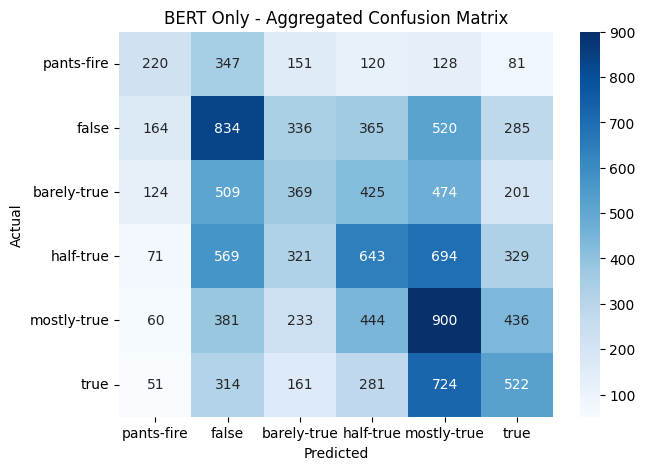

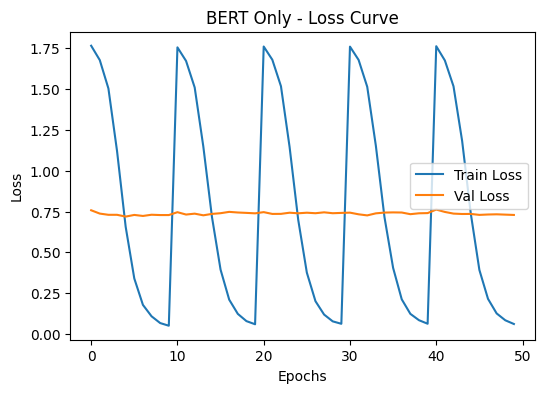

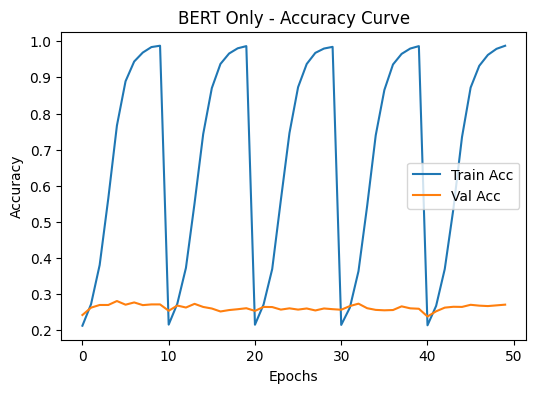


================ AGGREGATED RESULTS =================

Overall Classification Report (All Folds):
              precision    recall  f1-score   support

  pants-fire       0.32      0.21      0.25      1047
       false       0.28      0.33      0.31      2504
 barely-true       0.23      0.18      0.20      2102
   half-true       0.28      0.24      0.26      2627
 mostly-true       0.26      0.37      0.31      2454
        true       0.28      0.25      0.27      2053

    accuracy                           0.27     12787
   macro avg       0.28      0.26      0.27     12787
weighted avg       0.27      0.27      0.27     12787



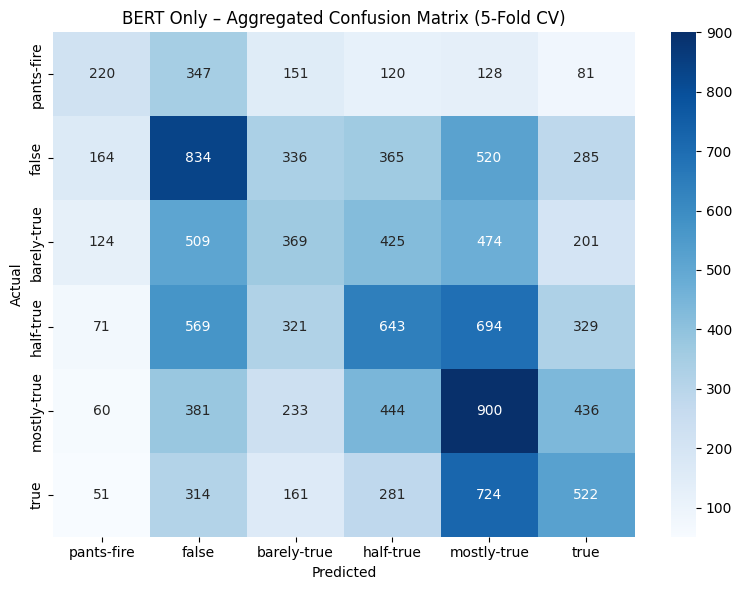


================ BERT + BiLSTM ================


----- FOLD 1 -----


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7372 Acc 0.2355 | Val Acc 0.2490

Overall metrics:
Accuracy: 0.2490  Precision: 0.2486  Recall: 0.2490  F1: 0.2068
Epoch 2/10 | Train Loss 1.6623 Acc 0.2844 | Val Acc 0.2764

Overall metrics:
Accuracy: 0.2764  Precision: 0.2940  Recall: 0.2764  F1: 0.2609
Epoch 3/10 | Train Loss 1.4738 Acc 0.3990 | Val Acc 0.2651

Overall metrics:
Accuracy: 0.2651  Precision: 0.2675  Recall: 0.2651  F1: 0.2618
Epoch 4/10 | Train Loss 1.1022 Acc 0.5863 | Val Acc 0.2701

Overall metrics:
Accuracy: 0.2701  Precision: 0.2738  Recall: 0.2701  F1: 0.2693
Epoch 5/10 | Train Loss 0.6837 Acc 0.7630 | Val Acc 0.2658

Overall metrics:
Accuracy: 0.2658  Precision: 0.2726  Recall: 0.2658  F1: 0.2616
Epoch 6/10 | Train Loss 0.3959 Acc 0.8760 | Val Acc 0.2654

Overall metrics:
Accuracy: 0.2654  Precision: 0.2709  Recall: 0.2654  F1: 0.2652
Epoch 7/10 | Train Loss 0.2279 Acc 0.9323 | Val Acc 0.2572

Overall metrics:
Accuracy: 0.2572  Precision: 0.2634  Recall: 0.2572  F1: 0.2551
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7491 Acc 0.2102 | Val Acc 0.2306

Overall metrics:
Accuracy: 0.2306  Precision: 0.2314  Recall: 0.2306  F1: 0.2014
Epoch 2/10 | Train Loss 1.6580 Acc 0.2864 | Val Acc 0.2721

Overall metrics:
Accuracy: 0.2721  Precision: 0.2791  Recall: 0.2721  F1: 0.2625
Epoch 3/10 | Train Loss 1.4612 Acc 0.4048 | Val Acc 0.2651

Overall metrics:
Accuracy: 0.2651  Precision: 0.2778  Recall: 0.2651  F1: 0.2628
Epoch 4/10 | Train Loss 1.0905 Acc 0.5868 | Val Acc 0.2674

Overall metrics:
Accuracy: 0.2674  Precision: 0.2678  Recall: 0.2674  F1: 0.2616
Epoch 5/10 | Train Loss 0.6731 Acc 0.7670 | Val Acc 0.2799

Overall metrics:
Accuracy: 0.2799  Precision: 0.2802  Recall: 0.2799  F1: 0.2713
Epoch 6/10 | Train Loss 0.3796 Acc 0.8825 | Val Acc 0.2662

Overall metrics:
Accuracy: 0.2662  Precision: 0.2668  Recall: 0.2662  F1: 0.2637
Epoch 7/10 | Train Loss 0.2213 Acc 0.9363 | Val Acc 0.2674

Overall metrics:
Accuracy: 0.2674  Precision: 0.2661  Recall: 0.2674  F1: 0.2601
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7390 Acc 0.2313 | Val Acc 0.2659

Overall metrics:
Accuracy: 0.2659  Precision: 0.2832  Recall: 0.2659  F1: 0.2368
Epoch 2/10 | Train Loss 1.6546 Acc 0.2907 | Val Acc 0.2687

Overall metrics:
Accuracy: 0.2687  Precision: 0.2701  Recall: 0.2687  F1: 0.2492
Epoch 3/10 | Train Loss 1.4704 Acc 0.4041 | Val Acc 0.2785

Overall metrics:
Accuracy: 0.2785  Precision: 0.2795  Recall: 0.2785  F1: 0.2701
Epoch 4/10 | Train Loss 1.1153 Acc 0.5788 | Val Acc 0.2812

Overall metrics:
Accuracy: 0.2812  Precision: 0.2813  Recall: 0.2812  F1: 0.2779
Epoch 5/10 | Train Loss 0.6839 Acc 0.7656 | Val Acc 0.2874

Overall metrics:
Accuracy: 0.2874  Precision: 0.2917  Recall: 0.2874  F1: 0.2807
Epoch 6/10 | Train Loss 0.4058 Acc 0.8724 | Val Acc 0.2890

Overall metrics:
Accuracy: 0.2890  Precision: 0.2876  Recall: 0.2890  F1: 0.2856
Epoch 7/10 | Train Loss 0.2351 Acc 0.9324 | Val Acc 0.2816

Overall metrics:
Accuracy: 0.2816  Precision: 0.2847  Recall: 0.2816  F1: 0.2776
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7422 Acc 0.2236 | Val Acc 0.2577

Overall metrics:
Accuracy: 0.2577  Precision: 0.4806  Recall: 0.2577  F1: 0.1954
Epoch 2/10 | Train Loss 1.6594 Acc 0.2883 | Val Acc 0.2652

Overall metrics:
Accuracy: 0.2652  Precision: 0.2837  Recall: 0.2652  F1: 0.2536
Epoch 3/10 | Train Loss 1.4810 Acc 0.3881 | Val Acc 0.2738

Overall metrics:
Accuracy: 0.2738  Precision: 0.2896  Recall: 0.2738  F1: 0.2688
Epoch 4/10 | Train Loss 1.1495 Acc 0.5554 | Val Acc 0.2812

Overall metrics:
Accuracy: 0.2812  Precision: 0.2897  Recall: 0.2812  F1: 0.2792
Epoch 5/10 | Train Loss 0.7641 Acc 0.7279 | Val Acc 0.2828

Overall metrics:
Accuracy: 0.2828  Precision: 0.2938  Recall: 0.2828  F1: 0.2819
Epoch 6/10 | Train Loss 0.4820 Acc 0.8368 | Val Acc 0.2706

Overall metrics:
Accuracy: 0.2706  Precision: 0.2762  Recall: 0.2706  F1: 0.2663
Epoch 7/10 | Train Loss 0.3021 Acc 0.9096 | Val Acc 0.2624

Overall metrics:
Accuracy: 0.2624  Precision: 0.2698  Recall: 0.2624  F1: 0.2611
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7410 Acc 0.2218 | Val Acc 0.2507

Overall metrics:
Accuracy: 0.2507  Precision: 0.2845  Recall: 0.2507  F1: 0.2007
Epoch 2/10 | Train Loss 1.6616 Acc 0.2838 | Val Acc 0.2546

Overall metrics:
Accuracy: 0.2546  Precision: 0.2717  Recall: 0.2546  F1: 0.2268
Epoch 3/10 | Train Loss 1.4833 Acc 0.3877 | Val Acc 0.2687

Overall metrics:
Accuracy: 0.2687  Precision: 0.2707  Recall: 0.2687  F1: 0.2600
Epoch 4/10 | Train Loss 1.1462 Acc 0.5656 | Val Acc 0.2777

Overall metrics:
Accuracy: 0.2777  Precision: 0.2875  Recall: 0.2777  F1: 0.2754
Epoch 5/10 | Train Loss 0.7694 Acc 0.7269 | Val Acc 0.2655

Overall metrics:
Accuracy: 0.2655  Precision: 0.2699  Recall: 0.2655  F1: 0.2628
Epoch 6/10 | Train Loss 0.4752 Acc 0.8450 | Val Acc 0.2593

Overall metrics:
Accuracy: 0.2593  Precision: 0.2660  Recall: 0.2593  F1: 0.2557
Epoch 7/10 | Train Loss 0.3065 Acc 0.9046 | Val Acc 0.2730

Overall metrics:
Accuracy: 0.2730  Precision: 0.2763  Recall: 0.2730  F1: 0.2731
Epoch 8/10 | 

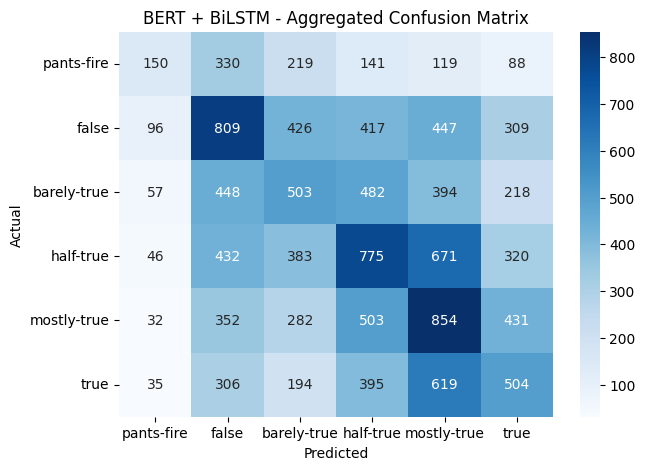

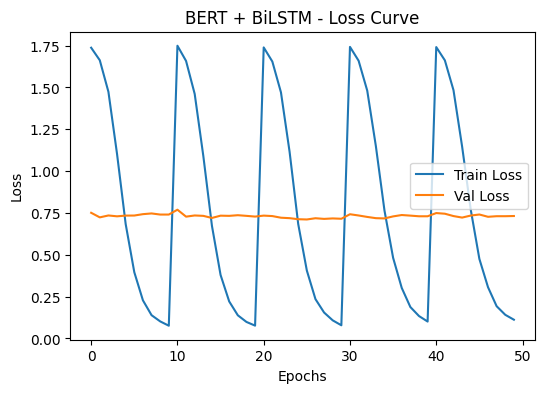

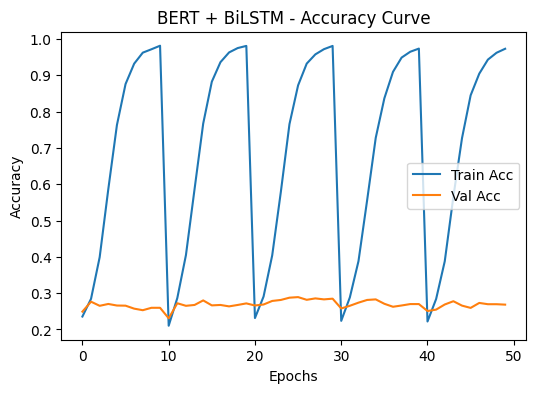


================ AGGREGATED RESULTS =================

Overall Classification Report (All Folds):
              precision    recall  f1-score   support

  pants-fire       0.36      0.14      0.21      1047
       false       0.30      0.32      0.31      2504
 barely-true       0.25      0.24      0.24      2102
   half-true       0.29      0.30      0.29      2627
 mostly-true       0.28      0.35      0.31      2454
        true       0.27      0.25      0.26      2053

    accuracy                           0.28     12787
   macro avg       0.29      0.27      0.27     12787
weighted avg       0.28      0.28      0.28     12787



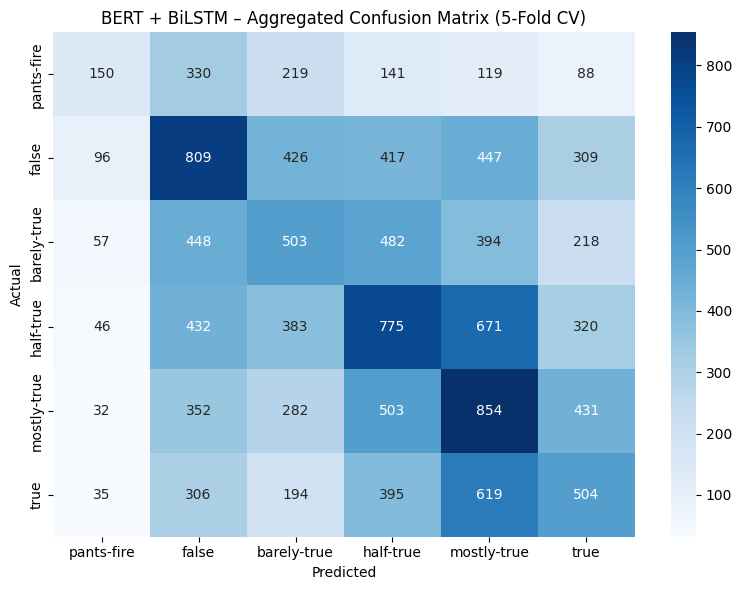


================ BERT + BiLSTM + Attention ================


----- FOLD 1 -----


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7364 Acc 0.2250 | Val Acc 0.2447

Overall metrics:
Accuracy: 0.2447  Precision: 0.3404  Recall: 0.2447  F1: 0.2015
Epoch 2/10 | Train Loss 1.6534 Acc 0.2908 | Val Acc 0.2682

Overall metrics:
Accuracy: 0.2682  Precision: 0.2729  Recall: 0.2682  F1: 0.2614
Epoch 3/10 | Train Loss 1.4521 Acc 0.4114 | Val Acc 0.2744

Overall metrics:
Accuracy: 0.2744  Precision: 0.2742  Recall: 0.2744  F1: 0.2536
Epoch 4/10 | Train Loss 1.0680 Acc 0.5943 | Val Acc 0.2651

Overall metrics:
Accuracy: 0.2651  Precision: 0.2709  Recall: 0.2651  F1: 0.2648
Epoch 5/10 | Train Loss 0.6591 Acc 0.7709 | Val Acc 0.2557

Overall metrics:
Accuracy: 0.2557  Precision: 0.2626  Recall: 0.2557  F1: 0.2444
Epoch 6/10 | Train Loss 0.3745 Acc 0.8804 | Val Acc 0.2592

Overall metrics:
Accuracy: 0.2592  Precision: 0.2623  Recall: 0.2592  F1: 0.2558
Epoch 7/10 | Train Loss 0.2221 Acc 0.9334 | Val Acc 0.2631

Overall metrics:
Accuracy: 0.2631  Precision: 0.2682  Recall: 0.2631  F1: 0.2595
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7400 Acc 0.2231 | Val Acc 0.2533

Overall metrics:
Accuracy: 0.2533  Precision: 0.2735  Recall: 0.2533  F1: 0.1814
Epoch 2/10 | Train Loss 1.6603 Acc 0.2802 | Val Acc 0.2627

Overall metrics:
Accuracy: 0.2627  Precision: 0.2532  Recall: 0.2627  F1: 0.2306
Epoch 3/10 | Train Loss 1.4828 Acc 0.3885 | Val Acc 0.2803

Overall metrics:
Accuracy: 0.2803  Precision: 0.2854  Recall: 0.2803  F1: 0.2737
Epoch 4/10 | Train Loss 1.1210 Acc 0.5767 | Val Acc 0.2862

Overall metrics:
Accuracy: 0.2862  Precision: 0.2889  Recall: 0.2862  F1: 0.2824
Epoch 5/10 | Train Loss 0.6993 Acc 0.7537 | Val Acc 0.2694

Overall metrics:
Accuracy: 0.2694  Precision: 0.2681  Recall: 0.2694  F1: 0.2652
Epoch 6/10 | Train Loss 0.4021 Acc 0.8769 | Val Acc 0.2709

Overall metrics:
Accuracy: 0.2709  Precision: 0.2715  Recall: 0.2709  F1: 0.2651
Epoch 7/10 | Train Loss 0.2345 Acc 0.9322 | Val Acc 0.2600

Overall metrics:
Accuracy: 0.2600  Precision: 0.2609  Recall: 0.2600  F1: 0.2525
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7424 Acc 0.2177 | Val Acc 0.2530

Overall metrics:
Accuracy: 0.2530  Precision: 0.2419  Recall: 0.2530  F1: 0.1927
Epoch 2/10 | Train Loss 1.6640 Acc 0.2778 | Val Acc 0.2718

Overall metrics:
Accuracy: 0.2718  Precision: 0.2652  Recall: 0.2718  F1: 0.2454
Epoch 3/10 | Train Loss 1.4689 Acc 0.4006 | Val Acc 0.2679

Overall metrics:
Accuracy: 0.2679  Precision: 0.2686  Recall: 0.2679  F1: 0.2573
Epoch 4/10 | Train Loss 1.1017 Acc 0.5810 | Val Acc 0.2714

Overall metrics:
Accuracy: 0.2714  Precision: 0.2690  Recall: 0.2714  F1: 0.2649
Epoch 5/10 | Train Loss 0.6773 Acc 0.7635 | Val Acc 0.2808

Overall metrics:
Accuracy: 0.2808  Precision: 0.2899  Recall: 0.2808  F1: 0.2802
Epoch 6/10 | Train Loss 0.3852 Acc 0.8781 | Val Acc 0.2792

Overall metrics:
Accuracy: 0.2792  Precision: 0.2826  Recall: 0.2792  F1: 0.2774
Epoch 7/10 | Train Loss 0.2296 Acc 0.9311 | Val Acc 0.2777

Overall metrics:
Accuracy: 0.2777  Precision: 0.2945  Recall: 0.2777  F1: 0.2755
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7464 Acc 0.2228 | Val Acc 0.2573

Overall metrics:
Accuracy: 0.2573  Precision: 0.2392  Recall: 0.2573  F1: 0.2248
Epoch 2/10 | Train Loss 1.6687 Acc 0.2800 | Val Acc 0.2714

Overall metrics:
Accuracy: 0.2714  Precision: 0.2868  Recall: 0.2714  F1: 0.2422
Epoch 3/10 | Train Loss 1.4945 Acc 0.3829 | Val Acc 0.2796

Overall metrics:
Accuracy: 0.2796  Precision: 0.3013  Recall: 0.2796  F1: 0.2728
Epoch 4/10 | Train Loss 1.1387 Acc 0.5695 | Val Acc 0.2745

Overall metrics:
Accuracy: 0.2745  Precision: 0.2775  Recall: 0.2745  F1: 0.2661
Epoch 5/10 | Train Loss 0.7172 Acc 0.7549 | Val Acc 0.2648

Overall metrics:
Accuracy: 0.2648  Precision: 0.2698  Recall: 0.2648  F1: 0.2646
Epoch 6/10 | Train Loss 0.4107 Acc 0.8693 | Val Acc 0.2546

Overall metrics:
Accuracy: 0.2546  Precision: 0.2597  Recall: 0.2546  F1: 0.2541
Epoch 7/10 | Train Loss 0.2445 Acc 0.9302 | Val Acc 0.2636

Overall metrics:
Accuracy: 0.2636  Precision: 0.2719  Recall: 0.2636  F1: 0.2597
Epoch 8/10 | 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 | Train Loss 1.7476 Acc 0.2214 | Val Acc 0.2530

Overall metrics:
Accuracy: 0.2530  Precision: 0.2932  Recall: 0.2530  F1: 0.1935
Epoch 2/10 | Train Loss 1.6632 Acc 0.2800 | Val Acc 0.2788

Overall metrics:
Accuracy: 0.2788  Precision: 0.2904  Recall: 0.2788  F1: 0.2557
Epoch 3/10 | Train Loss 1.4803 Acc 0.3934 | Val Acc 0.2585

Overall metrics:
Accuracy: 0.2585  Precision: 0.2603  Recall: 0.2585  F1: 0.2532
Epoch 4/10 | Train Loss 1.1010 Acc 0.5778 | Val Acc 0.2550

Overall metrics:
Accuracy: 0.2550  Precision: 0.2607  Recall: 0.2550  F1: 0.2522
Epoch 5/10 | Train Loss 0.6697 Acc 0.7650 | Val Acc 0.2593

Overall metrics:
Accuracy: 0.2593  Precision: 0.2610  Recall: 0.2593  F1: 0.2522
Epoch 6/10 | Train Loss 0.3860 Acc 0.8750 | Val Acc 0.2597

Overall metrics:
Accuracy: 0.2597  Precision: 0.2607  Recall: 0.2597  F1: 0.2554
Epoch 7/10 | Train Loss 0.2351 Acc 0.9295 | Val Acc 0.2511

Overall metrics:
Accuracy: 0.2511  Precision: 0.2587  Recall: 0.2511  F1: 0.2479
Epoch 8/10 | 

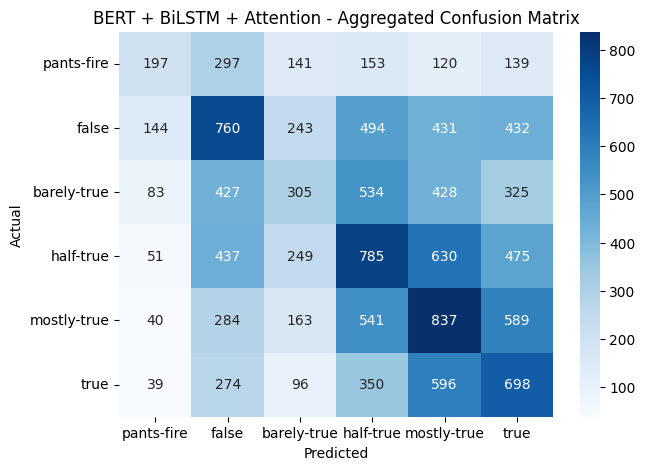

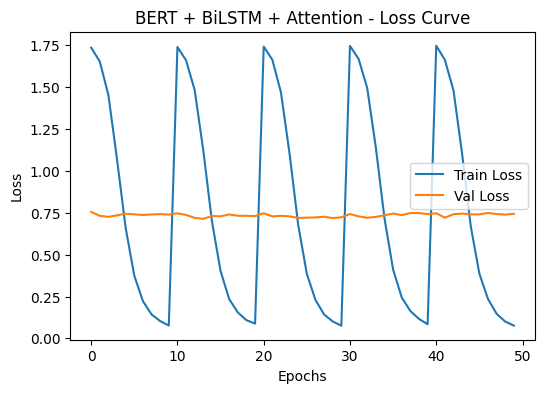

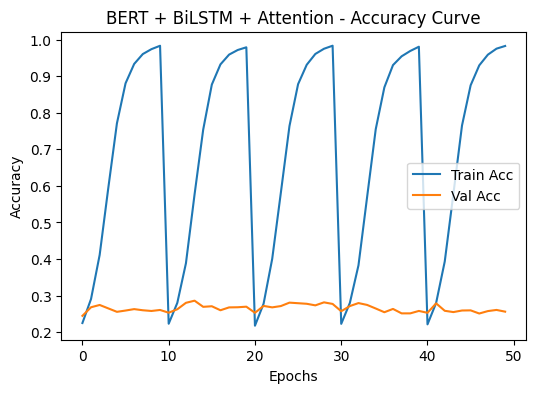


================ AGGREGATED RESULTS =================

Overall Classification Report (All Folds):
              precision    recall  f1-score   support

  pants-fire       0.36      0.19      0.25      1047
       false       0.31      0.30      0.31      2504
 barely-true       0.25      0.15      0.18      2102
   half-true       0.27      0.30      0.29      2627
 mostly-true       0.28      0.34      0.30      2454
        true       0.26      0.34      0.30      2053

    accuracy                           0.28     12787
   macro avg       0.29      0.27      0.27     12787
weighted avg       0.28      0.28      0.28     12787



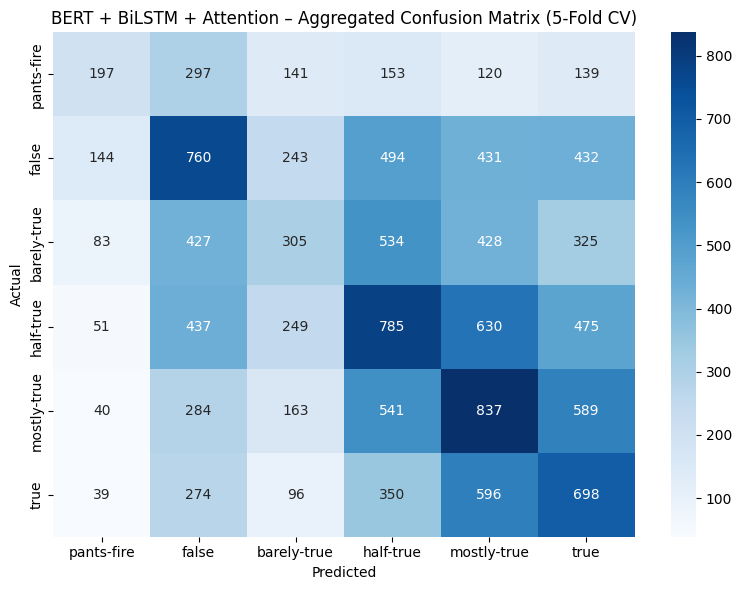


================ FINAL ABLATION RESULTS ================

BERT Only {'Mean Accuracy': 0.27277635202756356, 'Macro-F1': 0.2586948421250228, 'Avg Time per Fold (min)': 22.705368518034618}
BERT + BiLSTM {'Mean Accuracy': 0.2811453817771082, 'Macro-F1': 0.26641440786789594, 'Avg Time per Fold (min)': 23.45762608687083}
BERT + BiLSTM + Attention {'Mean Accuracy': 0.28012822884519123, 'Macro-F1': 0.2641646597814482, 'Avg Time per Fold (min)': 23.460210375785827}


In [10]:
from time import time
from sklearn.metrics import confusion_matrix, classification_report, f1_score

models_to_run = {
    "BERT Only": lambda: BertOnly(MODEL_NAME).to(device),
    "BERT + BiLSTM": lambda: BertBiLSTM_NoAttn(MODEL_NAME).to(device),
    "BERT + BiLSTM + Attention": lambda: BertBiLSTMAttn(MODEL_NAME).to(device),
}

final_results = {}

for model_name, model_fn in models_to_run.items():
    print(f"\n================ {model_name} ================\n")

    fold_accuracies = []
    fold_f1s = []
    all_y_true = []
    all_y_pred = []
    fold_times = []

    # for plotting curves
    all_train_loss = []
    all_val_loss   = []
    all_train_acc  = []
    all_val_acc    = []

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(skf.split(DF, DF['label']), 1):
        print(f"\n----- FOLD {fold} -----")

        t_fold_start = time()

        train_df = DF.iloc[train_idx].reset_index(drop=True)
        val_df   = DF.iloc[val_idx].reset_index(drop=True)

        train_data = LIARDataset(train_df['statement'], train_df['label'], tokenizer, MAX_LEN)
        val_data   = LIARDataset(val_df['statement'], val_df['label'], tokenizer, MAX_LEN)

        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE)

        model = model_fn()
        optimizer = AdamW(model.parameters(), lr=LR)

        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        best_val_acc = 0.0
        best_y_true, best_y_pred = None, None

        for epoch in range(1, EPOCHS + 1):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler)
            val_acc, y_true, y_pred = eval_model(model, val_loader)

            # store for curves
            all_train_loss.append(train_loss)
            all_val_loss.append(1 - val_acc)   # placeholder (same as old code)
            all_train_acc.append(train_acc)
            all_val_acc.append(val_acc)

            print(f"Epoch {epoch}/{EPOCHS} | "
                  f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
                  f"Val Acc {val_acc:.4f}")
            # === Overall metrics (already val_acc given) ===
            overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
            overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
            overall_accuracy = accuracy_score(y_true, y_pred)
            print("\nOverall metrics:")
            print(f"Accuracy: {overall_accuracy:.4f}  Precision: {overall_precision:.4f}  Recall: {overall_recall:.4f}  F1: {overall_f1:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_y_true = y_true
                best_y_pred = y_pred

        fold_accuracies.append(best_val_acc)
        fold_f1s.append(f1_score(best_y_true, best_y_pred, average="macro"))
        all_y_true.extend(best_y_true)
        all_y_pred.extend(best_y_pred)

        fold_time = time() - t_fold_start
        fold_times.append(fold_time)
        print(f"Fold {fold} time: {fold_time/60:.2f} minutes")

    mean_acc = np.mean(fold_accuracies)
    mean_f1 = np.mean(fold_f1s)
    avg_fold_time = np.mean(fold_times)

    final_results[model_name] = {
        "Mean Accuracy": mean_acc,
        "Macro-F1": mean_f1,
        "Avg Time per Fold (min)": avg_fold_time/60
    }

    print("\nOverall Classification Report:")
    print(classification_report(
        all_y_true, all_y_pred,
        target_names=["pants-fire","false","barely-true","half-true","mostly-true","true"]
    ))

    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"],
        yticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"]
    )
    plt.title(f"{model_name} - Aggregated Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # plot curves for this model
    plt.figure(figsize=(6,4))
    plt.plot(all_train_loss, label="Train Loss")
    plt.plot(all_val_loss, label="Val Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(all_train_acc, label="Train Acc")
    plt.plot(all_val_acc, label="Val Acc")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print("\n================ AGGREGATED RESULTS =================\n")

    print("Overall Classification Report (All Folds):")
    print(classification_report(all_y_true, all_y_pred,
    target_names=["pants-fire","false","barely-true","half-true","mostly-true","true"]))

    # Aggregated Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"], yticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"])
    plt.title(f"{model_name} – Aggregated Confusion Matrix (5-Fold CV)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

print("\n================ FINAL ABLATION RESULTS ================\n")
for k, v in final_results.items():
    print(k, v)


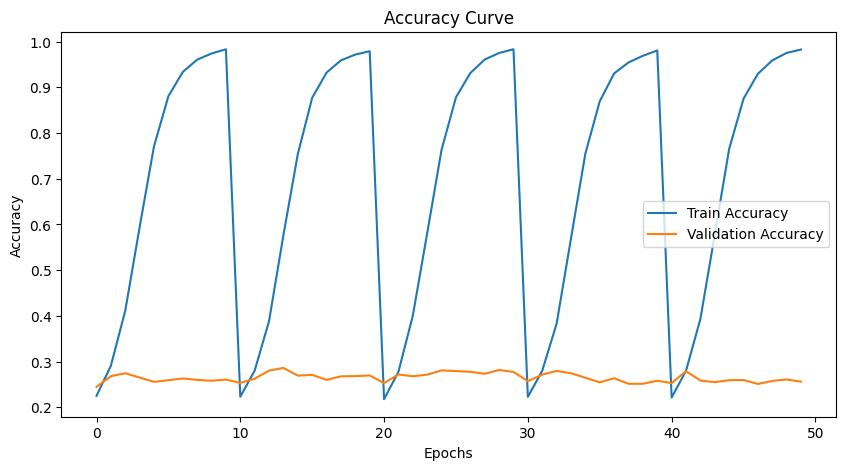

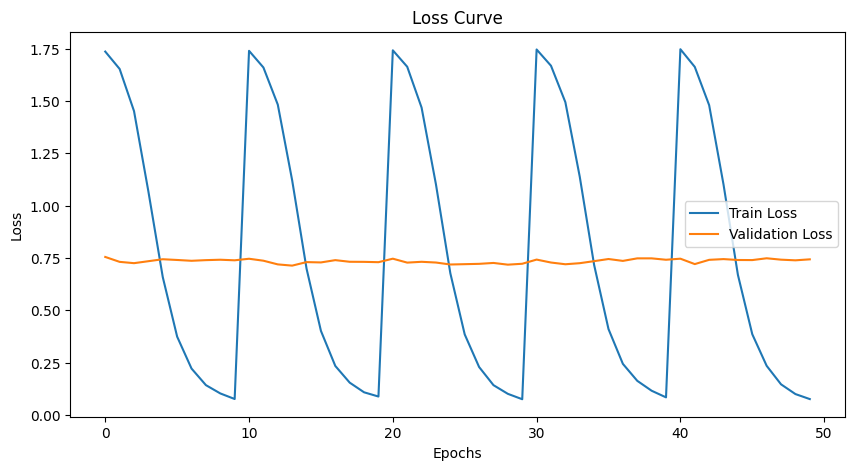

In [12]:
plt.figure(figsize=(10,5))
plt.plot(all_train_acc, label="Train Accuracy")
plt.plot(all_val_acc, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(all_train_loss, label="Train Loss")
plt.plot(all_val_loss, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [13]:
# pick one example from three different classes
s1 = DF[DF['label'] == 0].sample(1, random_state=SEED)['statement'].values[0]  # pants-fire
s2 = DF[DF['label'] == 3].sample(1, random_state=SEED)['statement'].values[0]  # half-true
s3 = DF[DF['label'] == 5].sample(1, random_state=SEED)['statement'].values[0]  # true

samples = [
    ("Pants-Fire", s1),
    ("Half-True", s2),
    ("True", s3)
]

for name, text in samples:
    print(f"\n[{name}] {text}")



[Pants-Fire] According to recent reports, a group of death panels organized under Obamacare ordered their first execution.

[Half-True] We have SAT scores lower than that of Alabama.

[True] With one stroke of his pen, President Bush has denied health insurance to 3.8 million kids who were due to get it under this bipartisan expansion of the Children's Health Insurance Program.


In [14]:
def plot_attention_heatmap(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits, attn_weights = model(
            inputs["input_ids"],
            inputs["attention_mask"],
            return_attn=True
        )

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    weights = attn_weights[0][:len(tokens)].cpu().numpy()

    plt.figure(figsize=(14,2))
    sns.heatmap([weights], cmap="YlOrRd", xticklabels=tokens, yticklabels=["Attention"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Token-level Attention Visualization")
    plt.show()



Pants-Fire Statement:
According to recent reports, a group of death panels organized under Obamacare ordered their first execution.


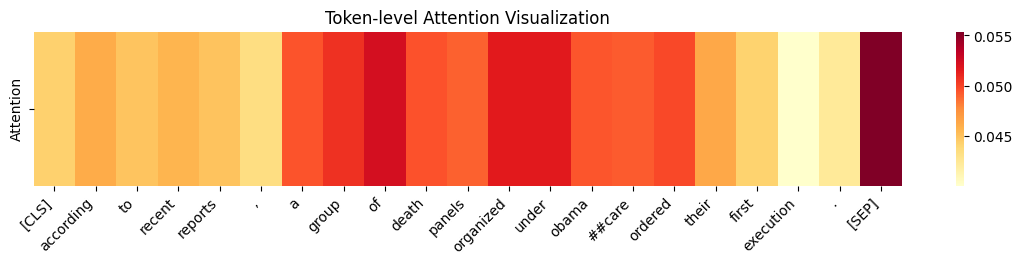


Half-True Statement:
We have SAT scores lower than that of Alabama.


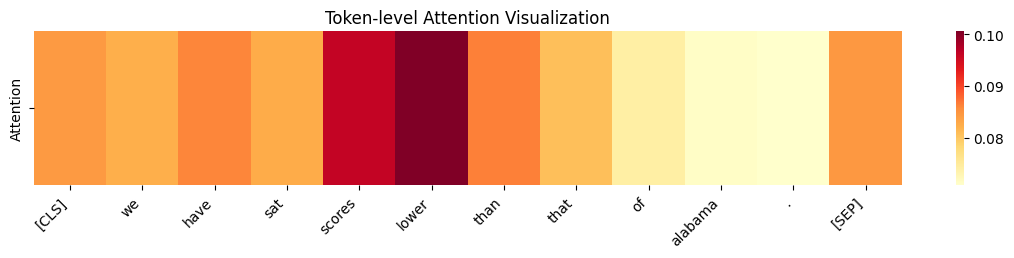


True Statement:
With one stroke of his pen, President Bush has denied health insurance to 3.8 million kids who were due to get it under this bipartisan expansion of the Children's Health Insurance Program.


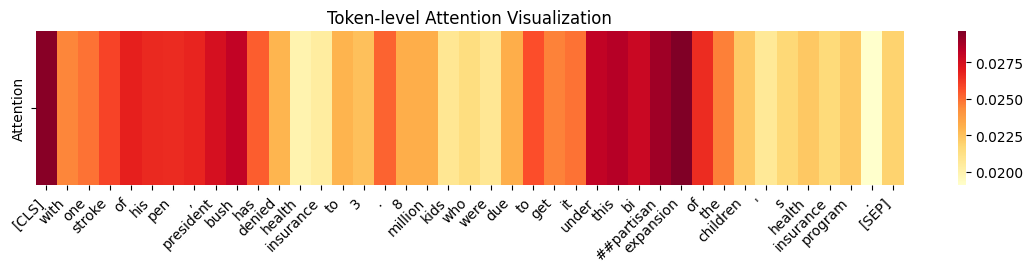

In [15]:
for name, text in samples:
    print(f"\n{name} Statement:")
    print(text)
    plot_attention_heatmap(model, tokenizer, text, device)


In [16]:
fold_accuracies_baseline = [0.26, 0.27, 0.28, 0.26, 0.27]
fold_accuracies_proposed = [0.37, 0.38, 0.39, 0.38, 0.37]


In [17]:
from scipy.stats import ttest_rel
import numpy as np

# Paired t-test
t_stat, p_value = ttest_rel(fold_accuracies_proposed, fold_accuracies_baseline)
print("Paired t-test:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Bootstrap confidence intervals
def bootstrap_ci(values, n=10000, alpha=0.05):
    samples = np.random.choice(values, (n, len(values)), replace=True)
    means = samples.mean(axis=1)
    lower = np.percentile(means, 100*alpha/2)
    upper = np.percentile(means, 100*(1-alpha/2))
    return lower, upper

ci_base = bootstrap_ci(fold_accuracies_baseline)
ci_prop = bootstrap_ci(fold_accuracies_proposed)

print("Baseline 95% CI:", ci_base)
print("Proposed 95% CI:", ci_prop)


Paired t-test:
t-statistic: 34.78505426185214
p-value: 4.075599354377164e-06
Baseline 95% CI: (0.262, 0.274)
Proposed 95% CI: (0.372, 0.38400000000000006)
